## Import all the important packeges

In [28]:
import time
from collections import deque, namedtuple
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as MSE
import os
import logging
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
from gymnasium.wrappers import RecordEpisodeStatistics


# setting the hyperparameters

In [29]:
memory_buffer=100_000
batch_size=64
gamma=0.99  #discount factor
alpha=0.001 #learning rate



# Environment Details

## Action Space
| Action | Description | Unit |
|--------|-------------|------|
| 0 | Apply -1 torque to the actuated joint | torque (N m) |
| 1 | Apply 0 torque to the actuated joint | torque (N m) |
| 2 | Apply 1 torque to the actuated joint | torque (N m) |

## Observation Space
| Index | Observation | Min | Max |
|-------|-------------|-----|-----|
| 0 | Cosine of theta1 | -1 | 1 |
| 1 | Sine of theta1 | -1 | 1 |
| 2 | Cosine of theta2 | -1 | 1 |
| 3 | Sine of theta2 | -1 | 1 |
| 4 | Angular velocity of theta1 | ~ -12.567 (-4 * pi) | ~ 12.567 (4 * pi) |
| 5 | Angular velocity of theta2 | ~ -28.274 (-9 * pi) | ~ 28.274 (9 * pi) |

### Angle Definitions
- **theta1**: Angle of the first joint (0° = pointing directly downwards)
- **theta2**: Angle relative to the first link (0° = same angle between links)

Angular velocities are bounded at ±4π and ±9π rad/s for theta1 and theta2 respectively.
A state of [1, 0, 1, 0, ..., ...] indicates both links pointing downwards.

## Rewards
- Goal: Reach target height in minimum steps
- Regular step: -1 reward
- Goal achieved: 0 reward and termination
- Reward threshold: -100

## Starting State
All parameters (theta1, theta2, and angular velocities) are initialized uniformly between -0.1 and 0.1, resulting in both links pointing downwards with slight randomness.

## Episode Termination Conditions
1. **Success**: Free end reaches target height
   - Condition: -cos(theta1) - cos(theta2 + theta1) > 1.0
2. **Truncation**: Episode length exceeds 500 steps




## Creating an enviornment

In [30]:
env = gym.make("Acrobot-v1", render_mode="rgb_array")

c:\Users\yugan\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\wrappers\rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


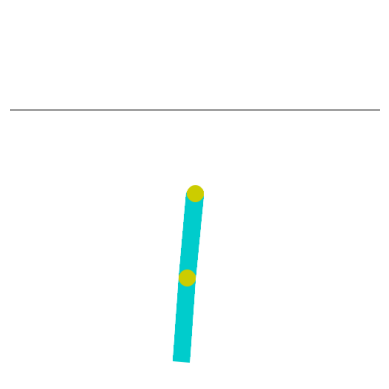

In [31]:
#this is to render the initial position of the environment
env.reset()
state=env.reset()
image=env.render()
plt.imshow(image)
plt.axis("off")
plt.show()

In [32]:
#this is to render a video of the environment
env = RecordVideo(env, video_folder='./video', episode_trigger=lambda x: x % 1 == 0)
observation, info = env.reset()

for _ in range(100):
    action = env.action_space.sample()  # Take a random action
    observation, reward, terminated, truncated, info = env.step(action)
    
    # Ensure rendering happens
    env.render()
    
    if terminated or truncated:
        break


env.close()

c:\Users\yugan\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\yugan\OneDrive\Documents\python\RL project\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [33]:
state=env.reset()
action=2
observation, reward, terminated, truncated, info = env.step(action)
print(observation)
print(reward)
print(terminated)
print(truncated)
print(info)
print(state)


[ 0.9982241   0.05957125  0.9993851   0.03506178 -0.21309187  0.4617512 ]
-1.0
False
False
{}
(array([ 0.99679434,  0.0800065 ,  0.9998612 , -0.01666118,  0.01431314,
        0.04290292], dtype=float32), {})


# Initlizing the q and target q network
the structure of both the networks will be the same

In [34]:
qnetwork=Sequential([
    Input(shape=(6,)), #input layer consist of 6 observations
    Dense(128, activation="relu"), #hidden layer 1
    Dense(128, activation="relu"), #hidden layer 2
    Dense(3, activation="linear") # 3 is the number of actions
])

target_qnetwork=Sequential([
    Input(shape=(6,)),
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(3, activation="linear")
])

# Initlizing the optimizer
optimizer=Adam(learning_rate=alpha)


creating a named tuple called experienced

In [35]:
experience=namedtuple("experience",["state","action","reward","next_state","done"])


In [42]:
#defining the loss function
def compute_loss(experiences,gamma,qnetwork,target_qnetwork):
    states,actions,rewards,next_states,done_vals=experiences
    max_qsa=tf.reduce_max(target_qnetwork(next_states),axis=1)
    y_targets=rewards+gamma*max_qsa*(1-done_vals)
    q_values=qnetwork(states)
    actions=tf.cast(actions,tf.int32)
    q_values=tf.gather_nd(q_values,tf.stack([tf.range(batch_size),actions],axis=1))
    loss = tf.reduce_mean(tf.square(y_targets - q_values))
    return loss




In [47]:
#defining the function to actually train the model

TAU=0.001 #soft update parameter

@tf.function
def train_step(experiences,gamma):
    with tf.GradientTape() as tape:
        loss=compute_loss(experiences,gamma,qnetwork,target_qnetwork)
    model_gradients=tape.gradient(loss,qnetwork.trainable_variables)
    optimizer.apply_gradients(zip(model_gradients,qnetwork.trainable_variables))
    #updating the target q network
    #target_qnetwork.set_weights(qnetwork.get_weights()) -- this is not optimal, this is also called hard update
    #instead we will soft update the target q network
    target_qnetwork.set_weights(
        tf.keras.utils.serialize_keras_object(qnetwork.get_weights())
    )
    for target_weights, q_net_weights in zip(target_qnetwork.trainable_variables, qnetwork.trainable_variables):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)  #this means that the target network will be updated with a small step towards the q network
    



In [48]:
#defining the e-greedy policy
epsilon=1.0
E_MIN=0.01
E_DECAY=0.995

#function to choose the action
def get_action(qvalues,epsilon=0):
    if np.random.rand()<epsilon:
        action=np.random.choice(np.arange(3))
    else:
        action=np.argmax(qvalues)
    return action
def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)
    


In [49]:
#utils for the coustom training loops
def check_update_conditions(t, num_steps_upd, memory):
    if (t + 1) % num_steps_upd == 0 and len(memory) > batch_size:
        return True
    else:
        return False
    
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=batch_size)
    states = tf.convert_to_tensor(np.array([e.state[0] for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None],dtype=np.int32), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.float32),dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

# Application of Deep Q-Learning Algorithm with Experience Replay

In [50]:
start=time.time()


env = RecordVideo(env, video_folder="acrobat-agent", name_prefix="training",
                  episode_trigger=lambda x: x % 200 == 0)
env = RecordEpisodeStatistics(env)

# Creating a memory buffer
memory=deque(maxlen=memory_buffer)
num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100

target_qnetwork.set_weights(qnetwork.get_weights())

for i in range(num_episodes):
    state,_=env.reset()
    total_points=0
    for t in range(max_num_timesteps):
        state=np.array(state)
        state=np.expand_dims(state, axis=0)
        qvalues=qnetwork(state)
        action=get_action(qvalues,epsilon)
        next_state,reward,done,truncated,info=env.step(action)
        memory.append(experience(state,action,reward,next_state,done))
        state=next_state
        total_points+=reward
        
        if check_update_conditions(t,5, memory):
            experiences=get_experiences(memory)
            train_step(experiences,gamma)
        
        state=next_state.copy()

        if done or truncated:
            break
    total_point_history.append(total_points)
    av_latest_points=np.mean(total_point_history[-num_p_av:])
    if i % 100 == 0:
        print(f"Episode {i} : av_latest_points {av_latest_points}")
    
    if av_latest_points >= 195.0:
        qnetwork.save("acrobat model.keras")
        print(f"Target Reached! on episode {i} and model saved")
        break
    
    epsilon=get_new_eps(epsilon)
    logging.info(f"episode-{num_episodes}", info["episode"])
env.close()
total_time=time.time()-start
print(f"Total Training Time: {total_time/60} minutes")



    



c:\Users\yugan\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\yugan\OneDrive\Documents\python\RL project\acrobat-agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


NotImplementedError: in user code:

    File "C:\Users\yugan\AppData\Local\Temp\ipykernel_24904\3256661627.py", line 14, in train_step  *
        target_qnetwork.set_weights(
    File "c:\Users\yugan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py", line 693, in get_weights  **
        return [v.numpy() for v in self.weights]
    File "c:\Users\yugan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py", line 693, in <listcomp>
        return [v.numpy() for v in self.weights]
    File "c:\Users\yugan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\core.py", line 71, in numpy
        return self.value.numpy()

    NotImplementedError: numpy() is only available when eager execution is enabled.


In [ ]:
#plotting the training progress
plt.figure(figsize=(10,5))
plt.plot(total_point_history)
plt.xlabel("Episode")
plt.ylabel("Total Points")
plt.title("Training Progress")
plt.show()
